<a href="https://www.kaggle.com/code/zulqarnain11/acne-classification-using-cnn?scriptVersionId=267292637" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Acne Classification Using CNN
## Goal:
Build a deep learning model to classify acne types using a CNN model, while addressing dataset imbalance through oversampling and augmentation.

## ----------------------------
## 1. IMPORTS
## ----------------------------

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## 📦 2. Download Dataset

In [58]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tiswan14/acne-dataset-image")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\tiswan14\acne-dataset-image\versions\1


## 📂 3. Dataset Paths & Parameters

In [ ]:
base_dir = r"C:\Users\DELL\.cache\kagglehub\datasets\tiswan14\acne-dataset-image\versions\1\AcneDataset"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

## 🧠 4. Load Datasets

In [60]:

# ----------------------------
# PARAMETERS
# ----------------------------
BATCH_SIZE = 32
IMAGE_SIZE = 128

# ----------------------------
# LOAD DATASETS
# ----------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=True
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)



Found 2778 files belonging to 5 classes.
Found 921 files belonging to 5 classes.
Found 918 files belonging to 5 classes.
Classes: ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Whiteheads']


## 🖼️ 5. Visualize Sample Images



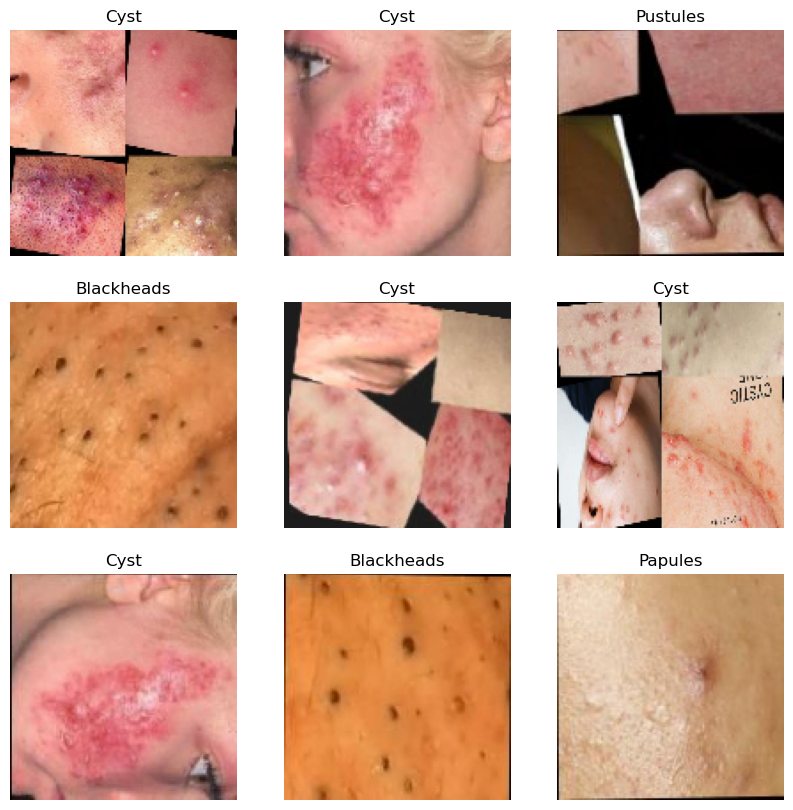

In [ ]:

for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))

        label_index = label[i].numpy()
        plt.title(class_names[label_index])

        plt.axis("off")


## 📊 6. Class Distribution

In [62]:
for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(base_dir, folder)
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):  # Only count directories
            print(f"{folder}/{cls}:", len(os.listdir(cls_path)))

train/Blackheads: 735
train/Cyst: 645
train/Papules: 621
train/Pustules: 584
train/Whiteheads: 193
valid/Blackheads: 240
valid/Cyst: 206
valid/Papules: 209
valid/Pustules: 217
valid/Whiteheads: 49
test/Blackheads: 265
test/Cyst: 189
test/Papules: 202
test/Pustules: 205
test/Whiteheads: 57


### 📌 Observation:
Whiteheads (193 images) are underrepresented, which can bias the model.
We'll fix this using oversampling and augmentation.

## ⚖️ 7. Compute Class Weights

In [ ]:
counts = [735, 645, 621, 584, 193]
classes = np.array([0,1,2,3,4])
y = np.repeat(classes, counts)
class_weight_dict = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y)))
print("Class weights:", class_weight_dict)



Class weights: {np.int64(0): np.float64(0.7559183673469387), np.int64(1): np.float64(0.8613953488372093), np.int64(2): np.float64(0.8946859903381642), np.int64(3): np.float64(0.9513698630136986), np.int64(4): np.float64(2.8787564766839377)}


## 🔧 8. Preprocessing & Normalization

In [ ]:
normalization_layer = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## 🔁 9. Data Augmentation

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.15)
])


## 🔄 10. Oversampling Minority Class (Whiteheads)

In [ ]:
# Unbatch the dataset
train_ds_unbatched = train_ds.unbatch()

# Split dataset by class
class_datasets = []
for i in range(len(class_names)):
    class_datasets.append(train_ds_unbatched.filter(lambda x, y: y==i))

# Oversample minority class (Whiteheads, index 4)
target_count = max(counts)
minority_index = 4
repeat_times = target_count // counts[minority_index]
remainder = target_count % counts[minority_index]

oversampled_class = class_datasets[minority_index].repeat(repeat_times)
oversampled_class = oversampled_class.concatenate(class_datasets[minority_index].take(remainder))
class_datasets[minority_index] = oversampled_class

# Combine all classes
balanced_ds = class_datasets[0]
for ds in class_datasets[1:]:
    balanced_ds = balanced_ds.concatenate(ds)

# Shuffle, augment, and batch correctly
balanced_ds = balanced_ds.shuffle(5000)
balanced_ds = balanced_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
balanced_ds = balanced_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### ✅ Result: 
The dataset is now balanced across all acne types.

In [ ]:
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## 🧰 11. Build CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,845 (2.55 MB)

 Trainable params: 667,845 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♂️ 12. Train Model


In [69]:
# ----------------------------
# CALLBACKS
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    balanced_ds,
    validation_data=valid_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/50
104/104 - 35s - 333ms/step - accuracy: 0.2611 - loss: 1.8038 - val_accuracy: 0.0901 - val_loss: 1.9534 - learning_rate: 1.0000e-03
Epoch 2/50
104/104 - 34s - 331ms/step - accuracy: 0.3063 - loss: 1.6347 - val_accuracy: 0.1716 - val_loss: 1.8364 - learning_rate: 1.0000e-03
Epoch 3/50


KeyboardInterrupt: 

## 📈 13. Evaluate Model

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

## 🔍 14. Confusion Matrix & Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)



In [ ]:
# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)


## 📊 15. Accuracy and Loss Curves


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()